## Processing User Data with the New Fields ##

In [1]:
# install the packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timedelta

In [36]:
# Read from CSV

userdata = pd.read_csv("data uploaded/user_data.csv")

# Process data: convert fields into the right data types

user_data = userdata.copy()
user_data["timestamp"] = pd.to_datetime(user_data["timestamp"])

# add new date column 

user_data["Date"] = pd.to_datetime(user_data["timestamp"]).dt.normalize()

In [37]:
user_data.head()

,timestamp,user_id,action,category,product_name,price,Date
0,2023-01-16 07:28:00,7fb12401-c1e9-4ede-9f55-fb571abec0cd,purchase,Books,Pride and Prejudice,14,2023-01-16
1,2023-01-16 12:20:00,9b0dd603-0beb-4d2f-866a-2a4563356b89,"view, click, view, view, view, click, view, vi...",Clothing,Sneakers,70,2023-01-16
2,2023-01-16 23:53:00,ba634991-ddf2-4d66-8ebc-73c6bfacdedb,"view, view, view, view, purchase",Home,Toaster,30,2023-01-16
3,2023-01-16 18:59:00,a393ec90-24f6-4ba0-8003-168bd9cbe7b1,purchase,Books,The Hobbit,16,2023-01-16
4,2023-01-16 14:17:00,9bb752fc-92bc-48b8-af40-8dea5f881e11,"view, click, click, purchase",Electronics,Gaming Console,400,2023-01-16


In [38]:
# Tackling "Action" field: extracting user actions to define attribution 

# Function to extract interactions
def extract_interactions(history, position):
    # Split the history string into a list
    entries = history.split(", ")
    # Check if the requested position exists (from the end)
    if len(entries) >= position:
        return entries[-position]
    return None  # Return None if the position doesn't exist

# Apply the function to create the columns
user_data["Last Interaction"] = user_data["action"].apply(lambda x: extract_interactions(x, 1))
user_data["Third Interaction"] = user_data["action"].apply(lambda x: extract_interactions(x, 2))
user_data["Second Interaction"] = user_data["action"].apply(lambda x: extract_interactions(x, 3))
user_data["First Interaction"] = user_data["action"].apply(lambda x: extract_interactions(x, 4))

In [39]:
# Create a new field "Sales_Channel" for attribution & further insights on the MMM

# Define probabilities for Sales_Channel when Last Interaction is "purchase"
sales_channel_probs = {
    "Search": 0.4,
    "Social": 0.25,
    "Video": 0.15,
    "Display": 0.10,
    "Digital Audio": 0.10
}

# Function to determine Sales_Channel
def determine_sales_channel(last_interaction):
    if last_interaction in ["view", "click"]:
        return "Offline"
    else:
        return np.random.choice(
            list(sales_channel_probs.keys()), 
            p=list(sales_channel_probs.values())
        )

# Apply the function to create the Sales_Channel column
user_data["Sales_Channel"] = user_data["Last Interaction"].apply(determine_sales_channel)

In [64]:
# Testing a new function in a copied dataframe
user_data2 = user_data.copy()

# Getting view counts and click counts out of the action section

click_probs = [0.35, 0.25, 0.15, 0.15, 0.1] # Search > Social > Video > Display > Audio
view_probs = [0.1, 0.2, 0.25, 0.3, 0.15]  # Display > Social > Video > Search > Audio
categories = ["Search", "Social", "Video", "Display", "Audio"]

# Function to distribute actions
def distribute_actions(actions):
    purchases = actions.count("purchase")
    clicks = actions.count("click") + purchases  # Purchases include 1 click each
    views = actions.count("view") + clicks  # Clicks (and purchases) include 1 view each
    
    # Distribute views and clicks based on probabilities
    view_distribution = np.random.multinomial(views, view_probs)
    click_distribution = np.random.multinomial(clicks, click_probs)
    
    # Create output dictionary
    output = {f"{category}_Views": view_distribution[i] for i, category in enumerate(categories)}
    output.update({f"{category}_Clicks": click_distribution[i] for i, category in enumerate(categories)})
    return output

# Apply the function and expand the result into new columns
distributions = user_data2["action"].apply(distribute_actions)
distributions_user_data2 = pd.DataFrame(list(distributions))

# Add the new columns to the original DataFrame
user_data3 = pd.concat([user_data2, distributions_user_data2], axis=1)

,timestamp,user_id,action,category,product_name,price,Date,Last Interaction,Third Interaction,Second Interaction,...,Search_Views,Social_Views,Video_Views,Display_Views,Audio_Views,Search_Clicks,Social_Clicks,Video_Clicks,Display_Clicks,Audio_Clicks
0,2023-01-16 07:28:00,7fb12401-c1e9-4ede-9f55-fb571abec0cd,purchase,Books,Pride and Prejudice,14,2023-01-16,purchase,None,None,...,0,0,0,1,0,0,0,0,1,0
1,2023-01-16 12:20:00,9b0dd603-0beb-4d2f-866a-2a4563356b89,"view, click, view, view, view, click, view, vi...",Clothing,Sneakers,70,2023-01-16,purchase,view,view,...,3,1,1,4,1,0,1,0,2,0
2,2023-01-16 23:53:00,ba634991-ddf2-4d66-8ebc-73c6bfacdedb,"view, view, view, view, purchase",Home,Toaster,30,2023-01-16,purchase,view,view,...,0,1,2,1,1,0,0,0,1,0
3,2023-01-16 18:59:00,a393ec90-24f6-4ba0-8003-168bd9cbe7b1,purchase,Books,The Hobbit,16,2023-01-16,purchase,None,None,...,0,0,0,0,1,0,1,0,0,0
4,2023-01-16 14:17:00,9bb752fc-92bc-48b8-af40-8dea5f881e11,"view, click, click, purchase",Electronics,Gaming Console,400,2023-01-16,purchase,click,click,...,1,1,1,1,0,1,1,0,1,0


In [107]:
# Feature Engineering

user_data3["Sales_Channel"].unique() # checking the number of unique values in Sales Channel
user_data3["category"].unique() # checking the number of unique values in Category
user_data4 = user_data3.copy()

# Import scikit-learn for OHE

from sklearn.preprocessing import OneHotEncoder

# OHE for Category

encoder = OneHotEncoder(drop=None,sparse_output=False)
category_encoded = encoder.fit_transform(user_data4[["category"]])
category_col_encoded = encoder.get_feature_names_out(["category"])
user_data4[category_col_encoded] = category_encoded

# OHE for Sales_Channel

saleschannel_encoded = encoder.fit_transform(user_data4[["Sales_Channel"]])
sales_cha_encoded = encoder.get_feature_names_out(["Sales_Channel"])
user_data4[sales_cha_encoded] = saleschannel_encoded

user_data4.columns

# weekly analysis - maybe a weekly rollup?



Index(['timestamp', 'user_id', 'action', 'category', 'product_name', 'price',
       'Date', 'Last Interaction', 'Third Interaction', 'Second Interaction',
       'First Interaction', 'Sales_Channel', 'Search_Views', 'Social_Views',
       'Video_Views', 'Display_Views', 'Audio_Views', 'Search_Clicks',
       'Social_Clicks', 'Video_Clicks', 'Display_Clicks', 'Audio_Clicks',
       'category_Books', 'category_Clothing', 'category_Electronics',
       'category_Home', 'Sales_Channel_Digital Audio', 'Sales_Channel_Display',
       'Sales_Channel_Offline', 'Sales_Channel_Search', 'Sales_Channel_Social',
       'Sales_Channel_Video'],
      dtype='object')

In [110]:
ud = user_data4
ud.head()
ud.columns

Index(['timestamp', 'user_id', 'action', 'category', 'product_name', 'price',
       'Date', 'Last Interaction', 'Third Interaction', 'Second Interaction',
       'First Interaction', 'Sales_Channel', 'Search_Views', 'Social_Views',
       'Video_Views', 'Display_Views', 'Audio_Views', 'Search_Clicks',
       'Social_Clicks', 'Video_Clicks', 'Display_Clicks', 'Audio_Clicks',
       'category_Books', 'category_Clothing', 'category_Electronics',
       'category_Home', 'Sales_Channel_Digital Audio', 'Sales_Channel_Display',
       'Sales_Channel_Offline', 'Sales_Channel_Search', 'Sales_Channel_Social',
       'Sales_Channel_Video'],
      dtype='object')

## Joining User Data with the Macro & Spend Data ##

In [67]:
# importing other notebook to join macro table with the user data

import import_ipynb
import MMM_macro_data 
daily = MMM_macro_data.daily

In [115]:
# Bringing the sum of revenue and sales on a daily rollup 

# Define the feature fields for summation
feature_engineered_sum = [
    'Search_Views', 'Social_Views', 'Video_Views', 'Display_Views', 'Audio_Views',
    'Search_Clicks', 'Social_Clicks', 'Video_Clicks', 'Display_Clicks', 'Audio_Clicks',
    'category_Books', 'category_Clothing', 'category_Electronics', 'category_Home',
    'Sales_Channel_Digital Audio', 'Sales_Channel_Display', 'Sales_Channel_Offline',
    'Sales_Channel_Search', 'Sales_Channel_Social', 'Sales_Channel_Video'
]

# Base aggregation dictionary
agg_dictionary = {
    "revenue": ("price", "sum"),
    "salescount": ("user_id", "count"),
    "searchclicks": ("Search_Clicks", "sum"),
    "search_impr": ("Search_Views", "sum")
}

# Update the dictionary dynamically for all feature fields
agg_dictionary.update({field: (field, "sum") for field in feature_engineered_sum})


# Perform groupby operation
ud_join = ud.groupby("Date").agg(**agg_dictionary)

# check the values

ud_join.head()

,revenue,salescount,searchclicks,search_impr,Search_Views,Social_Views,Video_Views,Display_Views,Audio_Views,Search_Clicks,...,category_Books,category_Clothing,category_Electronics,category_Home,Sales_Channel_Digital Audio,Sales_Channel_Display,Sales_Channel_Offline,Sales_Channel_Search,Sales_Channel_Social,Sales_Channel_Video
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,168846,996,607,337,337,664,853,1081,505,607,...,265.0,234.0,246.0,251.0,111.0,98.0,42.0,368.0,231.0,146.0
2023-01-03,164030,1006,629,340,340,691,843,1090,504,629,...,230.0,269.0,262.0,245.0,104.0,91.0,45.0,397.0,235.0,134.0
2023-01-04,163216,1011,643,380,380,687,905,1057,569,643,...,259.0,265.0,246.0,241.0,103.0,89.0,36.0,401.0,244.0,138.0
2023-01-05,178183,1006,628,354,354,648,863,1038,531,628,...,237.0,262.0,276.0,231.0,108.0,105.0,35.0,384.0,226.0,148.0
2023-01-06,162431,1005,582,363,363,696,812,1033,513,582,...,259.0,257.0,234.0,255.0,93.0,105.0,52.0,412.0,216.0,127.0


In [116]:
mmm_1 = daily.merge(ud_join, on = "Date", how="left") # Joining the user data with the macro data

In [117]:
# Macro data exploration

mmm_1.head()


,Date,Month,Year,Weekday,Trend_Factor,Promo_Exists,Consumer_Index,Inflation_Rate,Budget_Factor,Search_Factor,...,category_Books,category_Clothing,category_Electronics,category_Home,Sales_Channel_Digital Audio,Sales_Channel_Display,Sales_Channel_Offline,Sales_Channel_Search,Sales_Channel_Social,Sales_Channel_Video
0,2023-01-01,1,2023,6,1.05,0,110.7,8.7,1442724,0.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-02,1,2023,0,1.05,0,110.7,8.7,1442724,0.48,...,265.0,234.0,246.0,251.0,111.0,98.0,42.0,368.0,231.0,146.0
2,2023-01-03,1,2023,1,1.05,0,110.7,8.7,1442724,0.48,...,230.0,269.0,262.0,245.0,104.0,91.0,45.0,397.0,235.0,134.0
3,2023-01-04,1,2023,2,1.05,0,110.7,8.7,1442724,0.48,...,259.0,265.0,246.0,241.0,103.0,89.0,36.0,401.0,244.0,138.0
4,2023-01-05,1,2023,3,1.05,0,110.7,8.7,1442724,0.48,...,237.0,262.0,276.0,231.0,108.0,105.0,35.0,384.0,226.0,148.0


## MMM Joined Table EDA

In [119]:
mmm_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 0 to 730
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         731 non-null    datetime64[ns]
 1   Month                        731 non-null    int64         
 2   Year                         731 non-null    int64         
 3   Weekday                      731 non-null    int64         
 4   Trend_Factor                 731 non-null    float64       
 5   Promo_Exists                 731 non-null    int64         
 6   Consumer_Index               731 non-null    float64       
 7   Inflation_Rate               731 non-null    float64       
 8   Budget_Factor                731 non-null    int64         
 9   Search_Factor                731 non-null    float64       
 10  Display_Factor               731 non-null    float64       
 11  Video_Factor                 731 non-null    

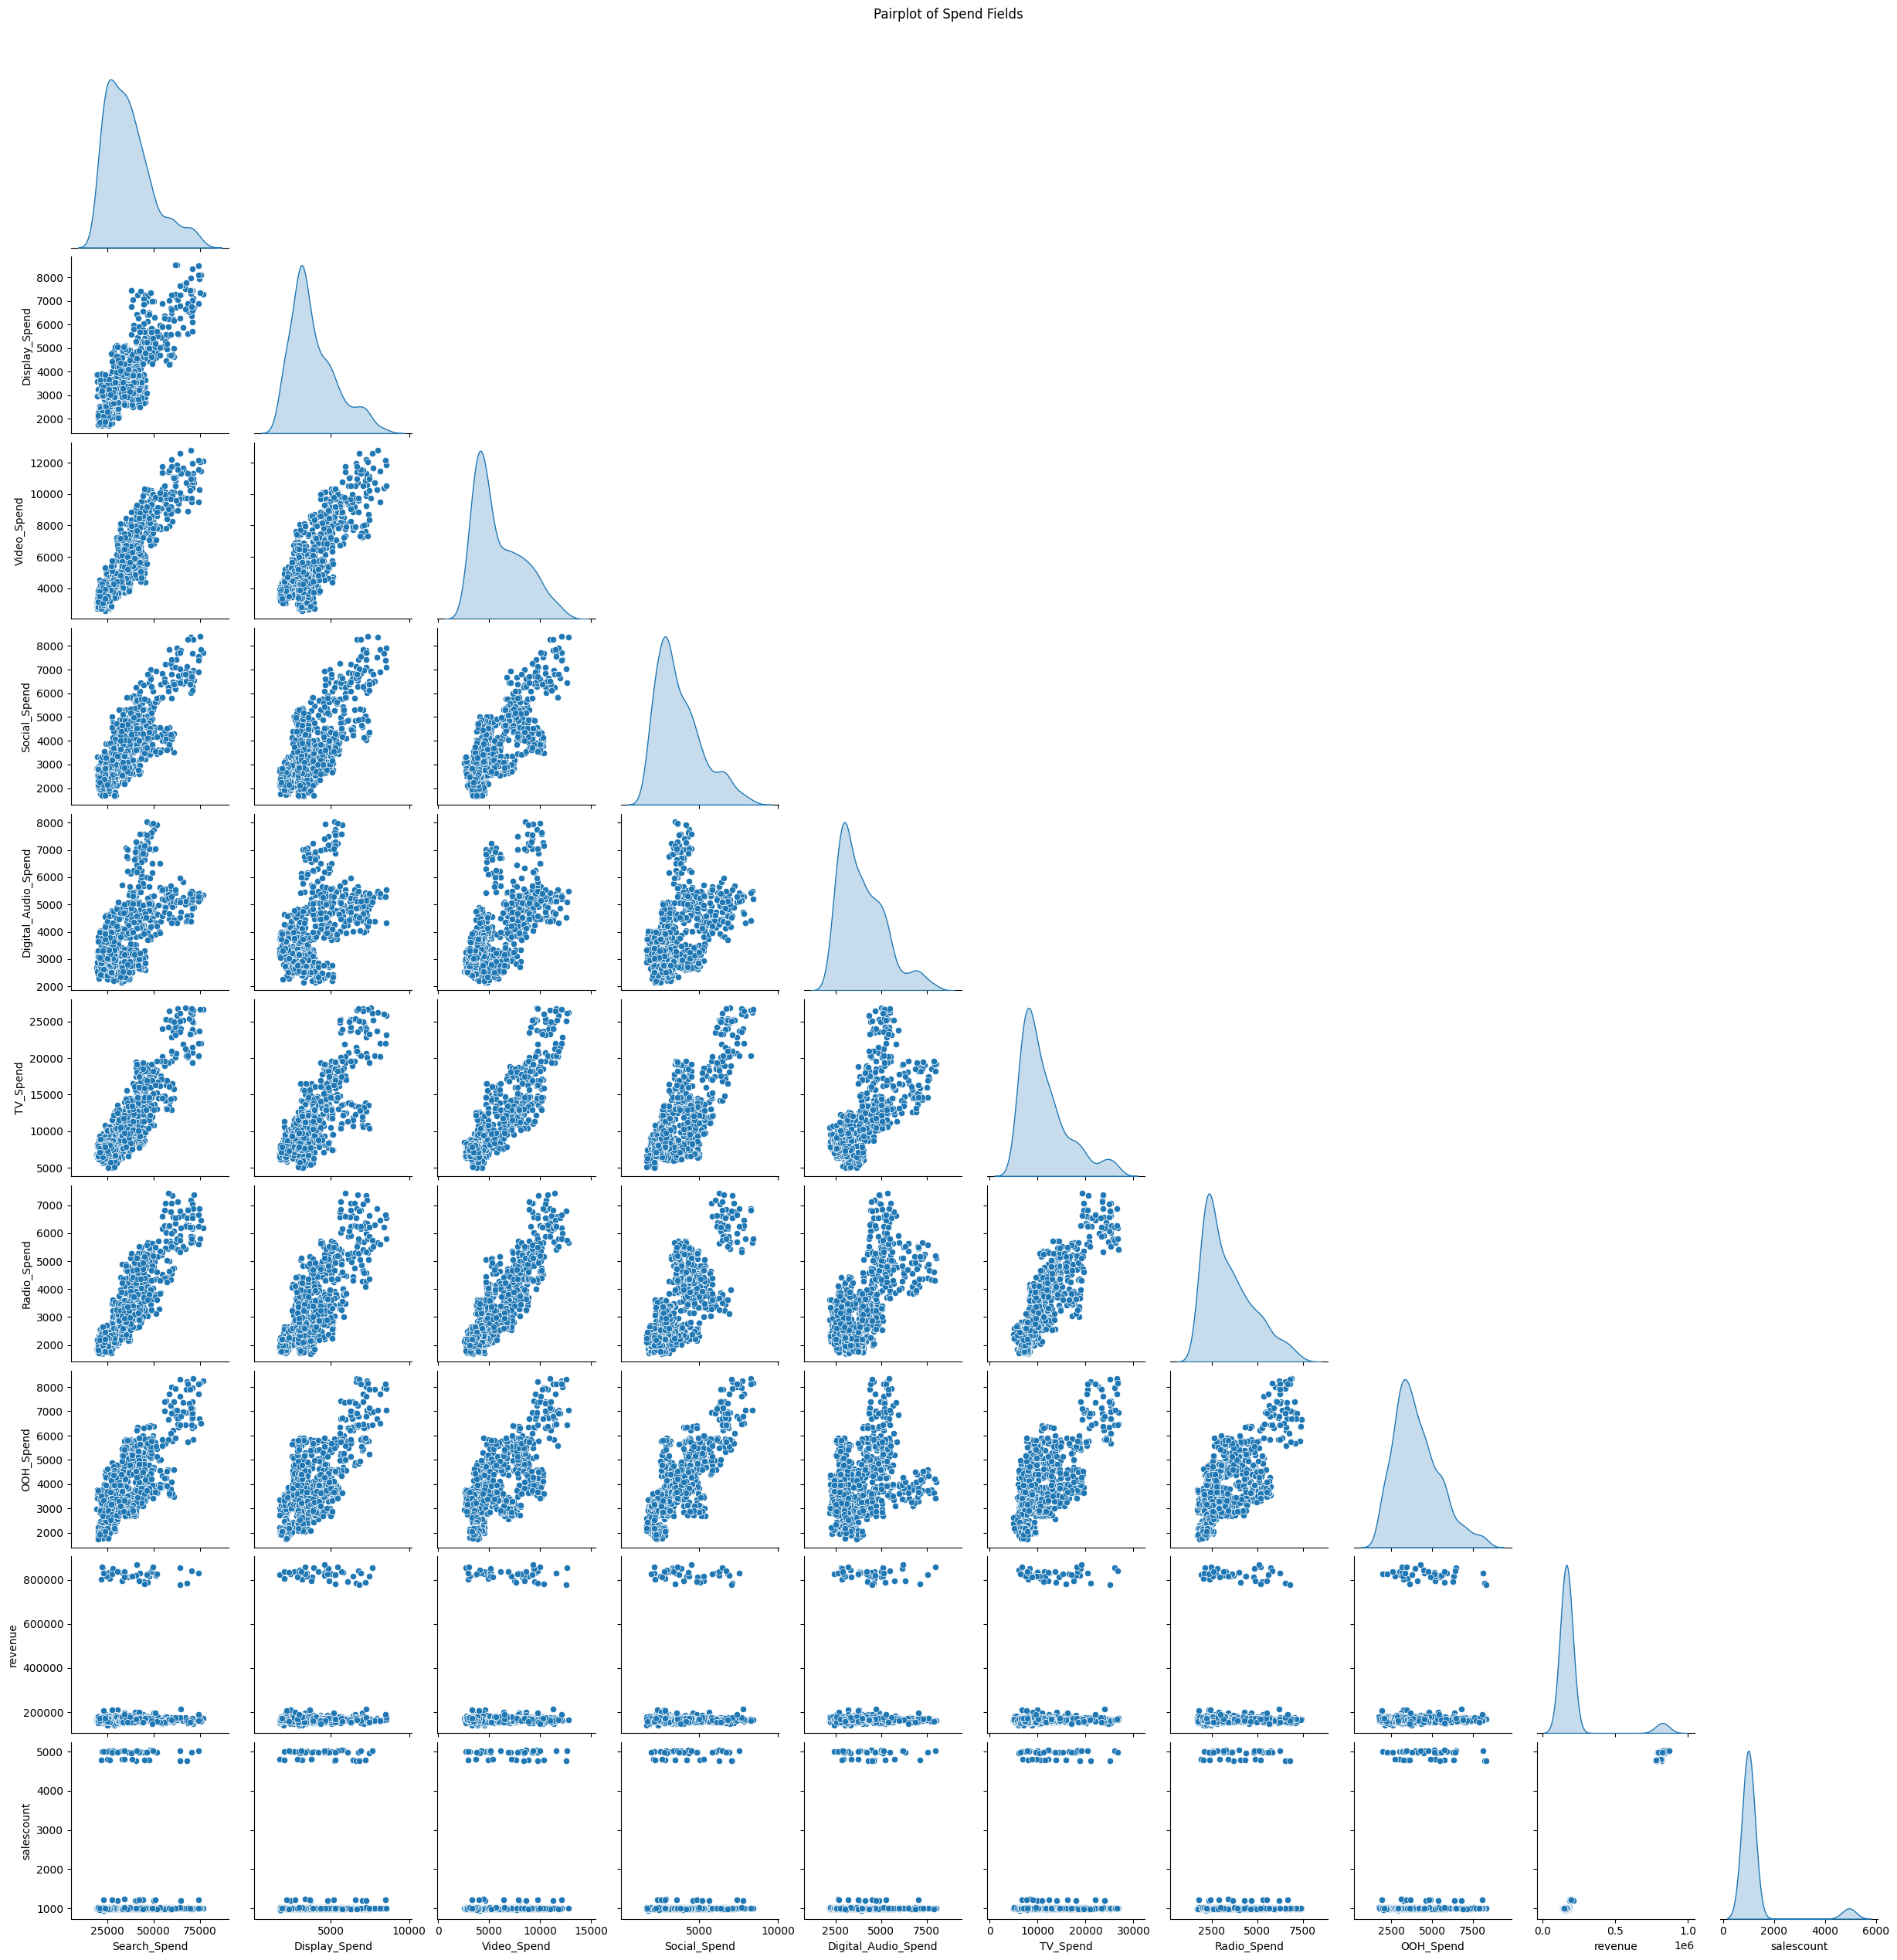

In [118]:
# Checking correlation & distribution

# Filter columns that contain 'Spend' in their names
spendc = [col for col in mmm_1.columns if "Spend" in col] + ["revenue", "salescount"]

# Create pairplot
sns.pairplot(mmm_1[spendc], diag_kind="kde", corner=True, height=2.5)

# Show the plot
plt.suptitle("Pairplot of Spend Fields", y=1.02)
plt.show()

<Axes: xlabel='Date', ylabel='salescount'>

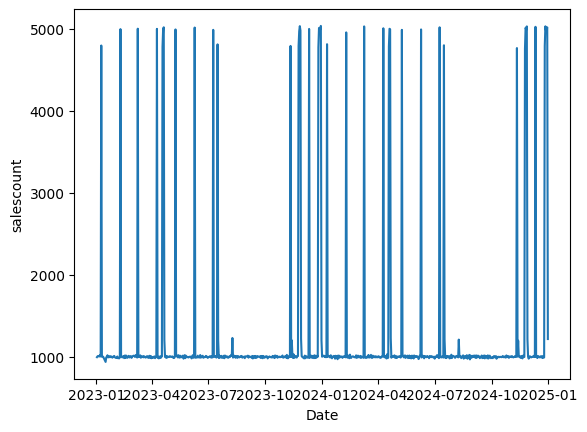

In [59]:
sns.lineplot(mmm_1, x="Date", y="salescount")